Directorio actual: c:\Users\jcdol\Downloads\Grupo Semana 4 Rev01\notebooks
Dimensiones del dataset: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1

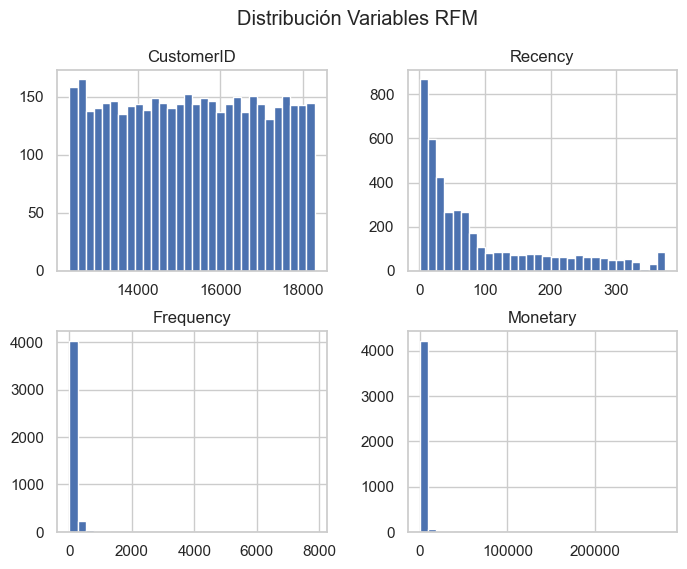

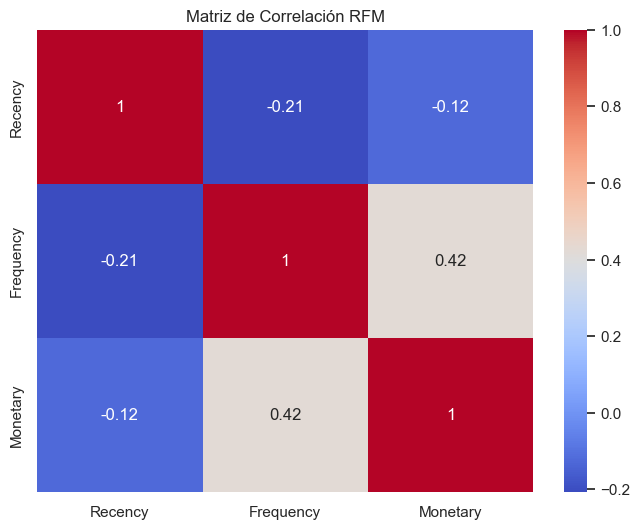

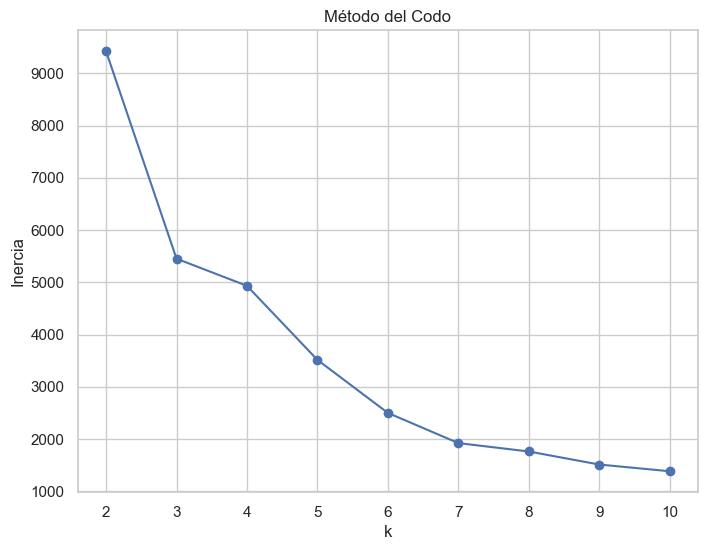

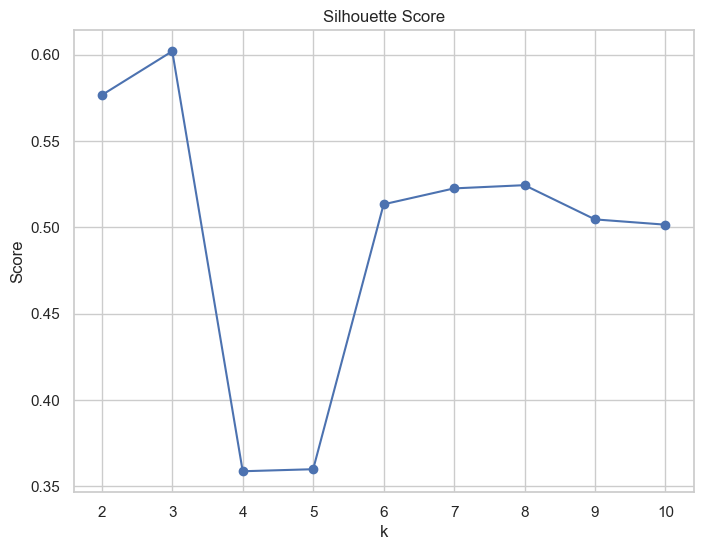

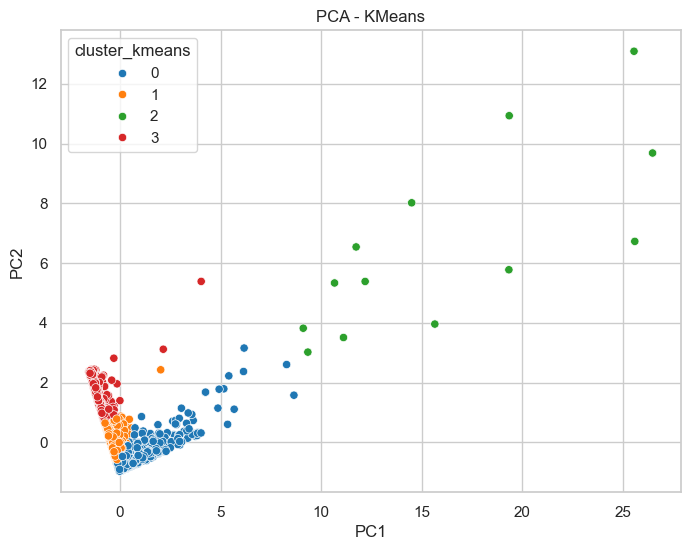

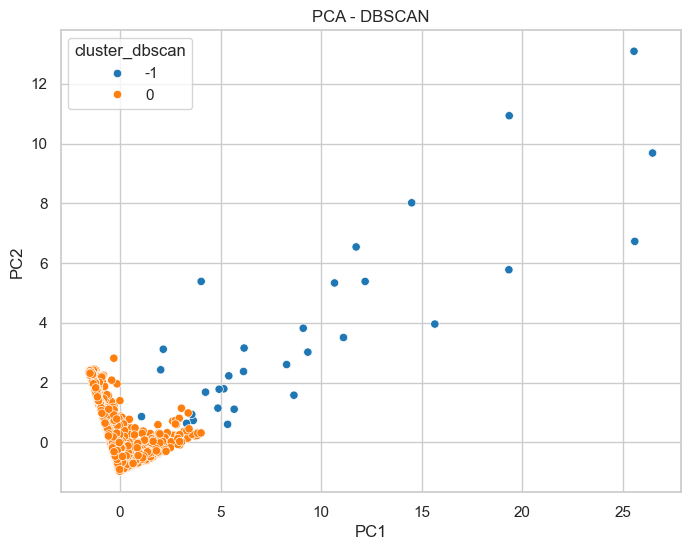

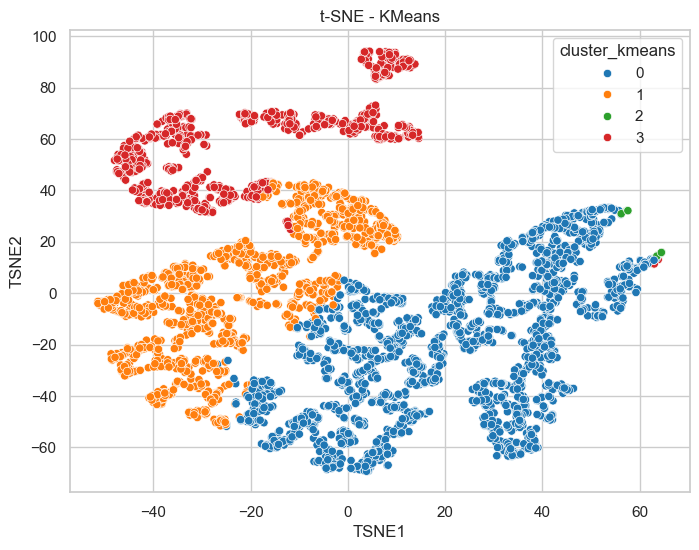

Resumen de clusters:
                   Recency    Frequency       Monetary
cluster_kmeans                                        
0                20.990788   135.285122    2645.818172
1                98.218703    37.719457     773.877083
2                 4.692308  2565.307692  126118.310000
3               272.407005    25.138889     605.842525

Archivos en carpeta figures:
['distribucion_rfm.png', 'elbow_kmeans.png', 'matriz_correlacion_rfm.png', 'pca_dbscan.png', 'pca_kmeans.png', 'perfiles_cluster_kmeans.csv', 'silhouette_kmeans.png', 'tsne_kmeans.png']


In [ ]:
# =========================================================
# Proyecto: Segmentación de Clientes con Clustering
# Dataset: Online Retail (Kaggle)
# Modelos: K-Means, DBSCAN, PCA y t-SNE
# =========================================================

# =========================
# 1. Importación de librerías
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set(style="whitegrid")

# =========================
# 2. Configuración carpeta figures
# =========================

FIGURES_PATH = "../figures"

if not os.path.exists(FIGURES_PATH):
    raise FileNotFoundError("La carpeta ../figures no existe")

print("✔ Guardando archivos en:", FIGURES_PATH)
print("Directorio actual:", os.getcwd())

# Función para guardar gráficos
def save_plot(nombre):
    plt.savefig(f"{FIGURES_PATH}/{nombre}", bbox_inches="tight")

# =========================
# 3. Carga del Dataset que se encuentra en el repositorio de Github
# =========================

file_path = "../data/OnlineRetail.csv"   # Ajusta si tu archivo está en otra carpeta

df = pd.read_csv(file_path, encoding="ISO-8859-1")

print("\nDimensiones:", df.shape)
print(df.head())

# =========================
# 4. Limpieza de Datos
# =========================

df.dropna(subset=["CustomerID"], inplace=True)

df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True)

df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

# =========================
# 5. Creación de Variables RFM
# =========================

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

print("\nRFM Head")
print(rfm.head())

# =========================
# 6. Exploratory Data Analysis (EDA)
# =========================

rfm.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribución Variables RFM")
save_plot("distribucion_rfm.png")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz Correlación RFM")
save_plot("matriz_correlacion_rfm.png")
plt.show()

# =========================
# 7. Preprocesamiento
# =========================

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# =========================
# 8. Método del Codo (K-Means)
# =========================

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.title("Método del Codo")
plt.xlabel("Clusters")
plt.ylabel("Inercia")
save_plot("elbow_kmeans.png")
plt.show()

# =========================
# 9. Silhouette Score
# =========================

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Score")
save_plot("silhouette_kmeans.png")
plt.show()

# =========================
# 10. K-Means Final
# =========================

k_optimo = 4

kmeans = KMeans(n_clusters=k_optimo, random_state=42)
rfm["Cluster_KMeans"] = kmeans.fit_predict(rfm_scaled)

# =========================
# 11. DBSCAN
# =========================

dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(rfm_scaled)

print("\nClusters DBSCAN:",
      len(set(rfm["Cluster_DBSCAN"])) -
      (1 if -1 in rfm["Cluster_DBSCAN"] else 0))

# =========================
# 12. PCA Visualización
# =========================

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

pca_df = pd.DataFrame(rfm_pca, columns=["PC1", "PC2"])
pca_df["Cluster_KMeans"] = rfm["Cluster_KMeans"]
pca_df["Cluster_DBSCAN"] = rfm["Cluster_DBSCAN"]

sns.scatterplot(data=pca_df, x="PC1", y="PC2",
                hue="Cluster_KMeans", palette="tab10")
plt.title("PCA - KMeans")
save_plot("pca_kmeans.png")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC2",
                hue="Cluster_DBSCAN", palette="tab10")
plt.title("PCA - DBSCAN")
save_plot("pca_dbscan.png")
plt.show()

# =========================
# 13. t-SNE
# =========================

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
rfm_tsne = tsne.fit_transform(rfm_scaled)

tsne_df = pd.DataFrame(rfm_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Cluster_KMeans"] = rfm["Cluster_KMeans"]
tsne_df["Cluster_DBSCAN"] = rfm["Cluster_DBSCAN"]

sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2",
                hue="Cluster_KMeans", palette="tab10")
plt.title("t-SNE - KMeans")
save_plot("tsne_kmeans.png")
plt.show()

sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2",
                hue="Cluster_DBSCAN", palette="tab10")
plt.title("t-SNE - DBSCAN")
save_plot("tsne_dbscan.png")
plt.show()

# =========================
# 14. Perfilamiento de Clusters
# =========================

kmeans_summary = rfm.groupby("Cluster_KMeans").mean()
kmeans_summary.to_csv(f"{FIGURES_PATH}/perfiles_cluster_kmeans.csv")

print("\nResumen KMeans")
print(kmeans_summary)

dbscan_filtered = rfm[rfm["Cluster_DBSCAN"] != -1]

if not dbscan_filtered.empty:
    dbscan_summary = dbscan_filtered.groupby("Cluster_DBSCAN").mean()
    dbscan_summary.to_csv(f"{FIGURES_PATH}/perfiles_cluster_dbscan.csv")

    print("\nResumen DBSCAN")
    print(dbscan_summary)

# =========================
# 15. Verificación Final
# =========================

print("\nArchivos generados:")
print(os.listdir(FIGURES_PATH))

print("\n✔ PROCESO COMPLETADO")
